In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='ticks',
        color_codes=True, rc={'legend.frameon': False})

%matplotlib inline

In [ ]:
import os
os.chdir('../')
os.getcwd()

## Training of GNN model (loss vs iteration)

In [17]:
def plot_loss(df, title="", ax=None):
    ax.semilogy(df.epoch, df.loss, label='Training loss')
    ax.semilogy(df.epoch, df.val_loss, label='Validation loss')
    ax.axhline(.1, ls='--', color='.4')
    ax.legend(prop={'size':10})
    # plt.ylim([0.05, 0.2])

    ax.set_title(title)
    ax.set_ylabel('Mean Absolute Error (eV/atom)', fontsize=14)
    ax.set_xlabel('Training Epoch', fontsize=14)
#     ax.tight_layout()
    # plt.savefig('figs/training_curve.svg')

In [18]:
def plot_loss_single(df, title=""):
    plt.semilogy(df.epoch, df.loss, label='Training loss')
    plt.semilogy(df.epoch, df.val_loss, label='Validation loss')
    plt.axhline(.1, ls='--', color='.4')
    plt.legend()
    # plt.ylim([0.05, 0.2])

    plt.title(title)
    plt.ylabel('Mean Absolute Error\neV/atom')
    plt.xlabel('Training Epoch')
    plt.tight_layout()
    # plt.savefig('figs/training_curve.svg')
    plt.show()
    plt.close()

In [19]:
def read_mae_file(mae_file):
    """ TODO improve this file 
    Example file:
    Test MAE: 0.153 eV/atom
    Test RMSE: 0.2562296566890987
    ICSD MAE: 0.076 eV/atom
    Hypo MAE: 0.164 eV/atom
    """
    mae_vals = pd.read_csv(mae_file, sep=' ', header=None).values
    if mae_vals[2][0] == "ICSD":
        icsd_mae = mae_vals[2][2]
        hypo_mae = mae_vals[3][2]
    else:
        icsd_mae = None
        hypo_mae = mae_vals[2][2]
    return icsd_mae, hypo_mae

In [20]:
def get_exp_description(exp, num_icsd=None, num_hypo=None):
    """ exp: experiment from yaml file
    """
    dataset_str = ', '.join(exp['datasets'])
    
    eval_sett = exp['eval_settings']
    icsd_str = ""
    if 'icsd' in exp['datasets']:
        icsd_str = f"{eval_sett['icsd_lattice']} lattice, {eval_sett['icsd']}"
        num_icsd_str = f" ({num_icsd})" if num_icsd is not None else ''
        icsd_str = f"ICSD eval{num_icsd_str}: {icsd_str}\n"

    hypo_str = f"{eval_sett['hypo_lattice']} lattice, {eval_sett['hypo']}"
    num_hypo_str = f" ({num_hypo})" if num_hypo is not None else ''
    hypo_str = f"Hypo eval{num_hypo_str}: {hypo_str}"
    
    eval_str = icsd_str + hypo_str
    return dataset_str, eval_str

In [21]:
def plot_train_and_parity(exp_dir, log_df, pred_df, icsd_df=None, out_dir=None):
    """ Plot the training curves and a parity plot

    :param pred_df: pandas dataframe containing the energy per atom
        as well as the predicted energy per atom
    :param icsd_df: pandas dataframe containing the IDs of ICSD structures
    """
    mae_file = exp_dir + "/mae_test.txt"
    icsd_mae, hypo_mae = read_mae_file(mae_file)

    f, (ax1, ax2) = plt.subplots(ncols=2, figsize=(9,4))
    
    plot_loss(log_df, ax=ax1)
    plot_parity(pred_df, hypo_mae, icsd_df=icsd_df, icsd_mae=icsd_mae, ax=ax2)
    
    # now get the title for the plot
    config_file = exp_dir + "/run.yaml"
    config_map = utils.load_config_file(config_file)    
    if icsd_df is not None:
        num_icsd = len(pred_df[pred_df.id.isin(icsd_df.id)])
        num_hypo = len(pred_df[~pred_df.id.isin(icsd_df.id)])
    else:
        num_icsd = None
        num_hypo = len(pred_df)
    dataset_str, eval_str = get_exp_description(config_map['experiments'][0],
                                                num_icsd=num_icsd,
                                                num_hypo=num_hypo,
                                                )
    
    plt.suptitle(dataset_str, y=1.15, fontweight='bold', fontsize=16)
    plt.figtext(x=.25, y=0.975, s=eval_str, fontsize=14, ha='left')
    
    plt.tight_layout()
    
    out_file = f"{exp_dir}/train_and_parity_plots.svg"
    plt.savefig(out_file, bbox_inches='tight')
    if out_dir is not None:
        out_file = f"{out_dir}/{'_'.join(exp_dir.split('/')[-2:])}.svg"
        print(f"writing {out_file}")
        plt.savefig(out_file, bbox_inches='tight')

    plt.show()
    plt.close()


def plot_parity(pred_df, hypo_mae, icsd_df=None, icsd_mae=None, ax=None, out_file=None):
    if icsd_df is not None:
        icsd_pred_df = pred_df[pred_df.id.isin(icsd_df.id)]
        hypo_pred_df = pred_df[~pred_df.id.isin(icsd_df.id)]
    else:
        hypo_pred_df = pred_df

    if ax is None:
        fig = plt.figure(figsize=(4,4))
        ax = fig.add_subplot(111, aspect='equal')
    if icsd_df is not None:
        ax.plot(icsd_pred_df.energyperatom, 
                icsd_pred_df.predicted_energyperatom, 
                '.', ms=2, c='b', 
                label=f'ICSD (MAE: {icsd_mae:0.3f})')
    ax.plot(hypo_pred_df.energyperatom, 
            hypo_pred_df.predicted_energyperatom, 
            '.', ms=2, c='r', 
            label=f'Hypothetical (MAE: {hypo_mae:0.3f})')
#     ax.plot([-9, -1], [-9, -1], '--', color='.8', zorder=0)
#     ax.set_xticks([-1, -3, -5, -7, -9])
#     ax.set_yticks([-1, -3, -5, -7, -9])
    ax.legend(loc='upper left', frameon=False, prop={'size':10}, markerscale=6)
#     plt.tick_params(direction='in', length=5)
    #plt.ylabel('Energy per atom,\npredicted (eV/atom)', fontsize=12)
    #plt.xlabel('Energy per atom,\nDFT (eV/atom)', fontsize=12)
    ax.set_ylabel('Predicted Total Energy (eV/atom)', fontsize=14)
    ax.set_xlabel('DFT Total Energy (eV/atom)', fontsize=14)

    ax.text(1, 0.025, f'Test MAE: {(pred_df.energyperatom - pred_df.predicted_energyperatom.squeeze()).abs().mean():.3f} eV/atom',
            ha='right', va='bottom', transform=ax.transAxes, fontsize=14)

    sns.despine(trim=False)
    if out_file is not None:
        plt.tight_layout()
        print("writing {out_file}")
        plt.savefig(out_file)

In [9]:
icsd_file = "inputs/structures/icsd_energies.csv"
icsd_df = pd.read_csv(icsd_file)

In [15]:
import glob
exp_dirs = list(glob.glob("outputs/icsd_*/*cos_sim*/*")) #+ list(glob.glob("outputs/icsd_*/*seed3"))

In [16]:
exp_dirs = [
#     "outputs/icsd_battery_unrelaxed/hypo_clatt_loc_icsd_randsub0_05_seed1",
#     "outputs/icsd_battery_unrelaxed/hypo_clatt_randsub0_05_icsd_randsub0_05_seed1",
#     "outputs/icsd_battery_unrelaxed/hypo_loc_icsd_randsub0_05_seed1",
#     "outputs/icsd_battery_relaxed_battery_unrelaxed/hypo_loc_icsd_randsub0_05_seed1",
#     "outputs/icsd_battery_unrelaxed/hypo_randsub0_05_icsd_randsub0_05_seed1",
#     "outputs/icsd_battery_relaxed_battery_unrelaxed/hypo_randsub0_05_icsd_randsub0_05_seed1",
#     "outputs/icsd_battery_relaxed/hypo_clatt_loc_icsd_randsub0_05_seed1",
#     "outputs/icsd_battery_relaxed/hypo_clatt_randsub0_05_icsd_randsub0_05_seed1",
#     "outputs/icsd_battery_relaxed/hypo_loc_icsd_randsub0_05_seed1",
#     "outputs/icsd_battery_relaxed/hypo_randsub0_05_icsd_randsub0_05_seed1",
#     "outputs/icsd_zintl_unrelaxed/hypo_clatt_loc_icsd_randsub0_05_seed1",
#     "outputs/icsd_zintl_unrelaxed/hypo_clatt_randsub0_05_icsd_randsub0_05_seed1",
#     "outputs/icsd_zintl_unrelaxed/hypo_loc_icsd_randsub0_05_seed1",
#     "outputs/icsd_zintl_unrelaxed/hypo_randsub0_05_icsd_randsub0_05_seed1",
#     "outputs/icsd_battery_unrelaxed/hypo_randsub0_05_icsd_randsub0_05_seed1_cutoff0_23/lr1e-04_ep100_bs64_ms256_mb2048_ed256_nm6",
#     "outputs/icsd_battery_unrelaxed/hypo_loc_icsd_randsub0_05_seed1_cutoff0_23/lr1e-04_ep100_bs64_ms256_mb2048_ed256_nm6",
#     "outputs/icsd_battery_unrelaxed/hypo_randsub0_05_icsd_randsub0_05_seed1_cutoff0_21/lr1e-04_ep100_bs64_ms256_mb2048_ed256_nm6",
#     "outputs/icsd_battery_unrelaxed/hypo_loc_icsd_randsub0_05_seed1_cutoff0_21/lr1e-04_ep100_bs64_ms256_mb2048_ed256_nm6",
#     "outputs/icsd_battery_unrelaxed/hypo_randsub0_05_icsd_randsub0_05_seed1_cutoff0_18/lr1e-04_ep100_bs64_ms256_mb2048_ed256_nm6",
#     "outputs/icsd_battery_unrelaxed/hypo_loc_icsd_randsub0_05_seed1_cutoff0_18/lr1e-04_ep100_bs64_ms256_mb2048_ed256_nm6",
#     "outputs/icsd_battery_unrelaxed/hypo_randsub0_05_icsd_randsub0_05_seed1_cutoff0_16/lr1e-04_ep100_bs64_ms256_mb2048_ed256_nm6",
#     "outputs/icsd_battery_unrelaxed/hypo_randsub0_05_icsd_randsub0_05_seed1_strc_cutoff0_19/lr1e-04_ep100_bs64_ms256_mb2048_ed256_nm6",
#     "outputs/icsd_battery_unrelaxed/hypo_loc_icsd_randsub0_05_seed1_strc_cutoff0_19/lr1e-04_ep100_bs64_ms256_mb2048_ed256_nm6",
#     "outputs/icsd_battery_unrelaxed_norm/hypo_randsub0_05_icsd_randsub0_05_seed1/lr1e-04_ep100_bs64_ms256_mb2048_ed256_nm6",
#     "outputs/icsd_battery_unrelaxed_norm/hypo_clatt_randsub0_05_icsd_randsub0_05_seed1/lr1e-04_ep100_bs64_ms256_mb2048_ed256_nm6",
#     "outputs/icsd_oqmd_relaxed/hypo_randsub0_25_icsd_randsub0_05_seed1/lr1e-04_ep100_bs64_ms256_mb2048_ed256_nm6",
#     "outputs/icsd_oqmd_unrelaxed/hypo_randsub0_25_icsd_randsub0_05_seed1/lr1e-04_ep100_bs64_ms256_mb2048_ed256_nm6",
#     "outputs/icsd_battery_unrelaxed/hypo_randsub0_05_volrel_icsd_randsub0_05_volrel_seed1/lr1e-04_ep100_bs64_ms256_mb2048_ed256_nm6",
#     "outputs/icsd_battery_unrelaxed_norm/hypo_randsub0_05_volrel_icsd_randsub0_05_volrel_seed1/lr1e-04_ep100_bs64_ms256_mb2048_ed256_nm6",
#     "outputs/battery_unrelaxed/hypo_randsub0_05_seed1/lr1e-04_ep100_bs64_ms256_mb2048_ed256_nm6",
    "outputs/battery_unrelaxed/hypo_randsub0_05_seed1/lr1e-04_ep100_bs64_ms256_mb2048_ed256_nm6wcos_dist",
]

Loading config file 'outputs/battery_unrelaxed/hypo_randsub0_05_seed1/lr1e-04_ep100_bs64_ms256_mb2048_ed256_nm6wcos_dist/run.yaml'
writing outputs/viz/train_and_parity/hypo_randsub0_05_seed1_lr1e-04_ep100_bs64_ms256_mb2048_ed256_nm6wcos_dist.svg


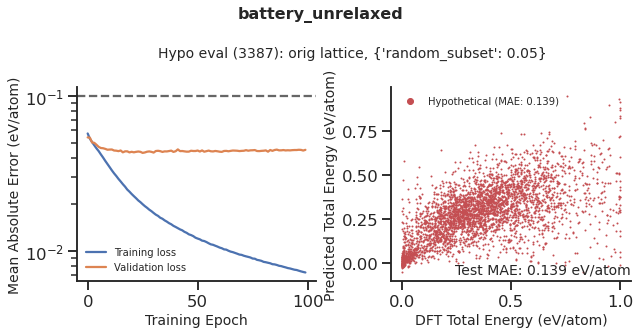

In [22]:
# print("min_val_loss\tepochs\tlog_file")
out_dir = "outputs/viz/train_and_parity"
os.makedirs(out_dir, exist_ok=True)

for exp_dir in exp_dirs:
    log_file = exp_dir + '/log.csv'
    if not os.path.isfile(log_file):
        continue
    df = pd.read_csv(log_file)
    pred_energy_file = exp_dir + '/predicted_test.csv'
    pred_df = pd.read_csv(pred_energy_file)
#     print(f"{df['val_loss'].min():0.2f}\t{df['val_loss'].argmin()}\t{log_file}")
    plot_train_and_parity(
        exp_dir, df, pred_df, 
#         icsd_df,
        icsd_df=None, out_dir=out_dir)